In [245]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [246]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [247]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [248]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    e = y - tx @ w
    N = y.shape[0]
    # ***************************************************
    return (1/(2*N)) * e.T @ e

In [249]:
w = np.array([1, 2])
compute_loss(y, tx, w)

2694.483365887085

# 2. Grid Search

Fill in the function `grid_search()` below:

In [250]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    for i in range(losses.shape[0]):
        for j in range(losses.shape[1]):
            w = np.array([grid_w0[i], grid_w1[j]])
            losses[i][j] = compute_loss(y, tx, w)
    # ***************************************************
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.79354101952324, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.324 seconds


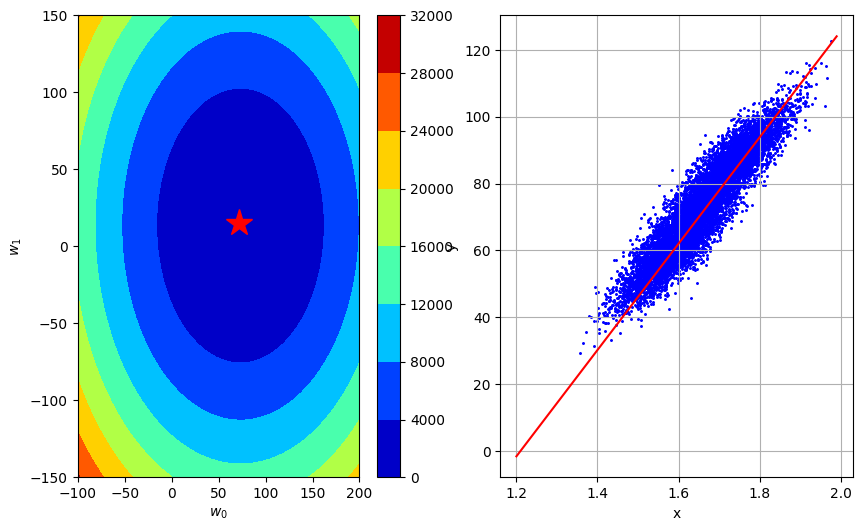

In [251]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [252]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    N = y.shape[0]
    e = y - tx @ w
    # ***************************************************
    return (-1/N) * tx.T @ e

print(compute_gradient(y, tx, np.array([1, 2])))
print(compute_gradient(y, tx, np.array([100, 20])))
print(compute_gradient(y, tx, np.array([50, 10])))

[-72.293922   -11.47971243]
[26.706078    6.52028757]
[-23.293922    -3.47971243]


Please fill in the functions `gradient_descent` below:

In [253]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # compute gradient and loss
        loss = compute_loss(y, tx, w)
        grad = compute_gradient(y, tx, w)
        # ***************************************************
        # update w by gradient
        w = w - gamma * grad
        # ***************************************************
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [254]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.2367127591674, w0=51.30574540147363, w1=9.435798704492301
GD iter. 1/49: loss=265.30246210895996, w0=66.69746902191574, w1=12.266538315840002
GD iter. 2/49: loss=37.87837955044107, w0=71.31498610804834, w1=13.115760199244328
GD iter. 3/49: loss=17.41021212017447, w0=72.70024123388814, w1=13.37052676426563
GD iter. 4/49: loss=15.568077051450452, w0=73.11581777164007, w1=13.446956733772023
GD iter. 5/49: loss=15.402284895265302, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=15.387363601208634, w0=73.27789262136332, w1=13.476764421879516
GD iter. 7/49: loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638305, w0=73.29348920882516, w1=13.47963283863509
GD iter. 10/49: loss=15.385887965652199, w0=73.29379216412119, w1=13.479688556082861
GD iter. 11/49: loss=15.38588787754345, w0=73.29388305071, w1=13.479705271317192
G

In [255]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [256]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    # ***************************************************
    # implement stochastic gradient computation. It's the same as the usual gradient.
    return compute_gradient(y, tx, w) 

def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # implement stochastic gradient descent.
        # ***************************************************
        # compute gradient and loss
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            w = w - gamma * compute_stoch_gradient(minibatch_y, minibatch_tx, w)
            
        loss = compute_loss(y, tx, w)
        ws.append(w)
        losses.append(loss)

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [257]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2030.2433035234058, w0=9.889810912200023, w1=10.37591988262392
SGD iter. 1/49: loss=1712.5651867469114, w0=15.713825627006349, w1=4.597646279499401
SGD iter. 2/49: loss=1302.2006600959564, w0=22.742271900851552, w1=17.741192986942366
SGD iter. 3/49: loss=1078.688345588763, w0=27.669849067627162, w1=20.19155899978
SGD iter. 4/49: loss=885.0847894279175, w0=32.15387388898994, w1=20.327649669568373
SGD iter. 5/49: loss=760.4581198235437, w0=35.87361906994599, w1=22.959448316060055
SGD iter. 6/49: loss=675.1502599629882, w0=38.393972944080524, w1=23.555539941233874
SGD iter. 7/49: loss=598.2537028650312, w0=41.66087040539035, w1=26.32827954077867
SGD iter. 8/49: loss=558.4161298457786, w0=43.61034508316855, w1=27.79563871488688
SGD iter. 9/49: loss=334.68936757852276, w0=48.86836437962033, w1=19.960383252895028
SGD iter. 10/49: loss=244.12414879060293, w0=52.12596823350623, w1=16.544717344284308
SGD iter. 11/49: loss=198.18402308663264, w0=54.33764206616182, w1=15.9808

In [258]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [259]:
import datetime
from helpers import *

# ***************************************************
# reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [260]:
y.shape, tx.shape

((202,), (202, 2))

In [261]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
# and the model fit
# ***************************************************
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.835114535854, w0=51.84746409844846, w1=7.724426406192428
GD iter. 1/49: loss=318.2821247015954, w0=67.40170332798299, w1=10.041754328050121
GD iter. 2/49: loss=88.6423556165127, w0=72.06797509684336, w1=10.736952704607413
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574597
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631794
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248088, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038408
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140234, w0=74.06776649225755, w1=11.03488900159354
GD iter. 

In [262]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [263]:
def compute_loss_mae(y, tx, w):
    """Calculate the loss using MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    e = y - tx @ w
    N = y.shape[0]
    # ***************************************************
    return (1/N) * np.sum(np.abs(e))

compute_loss_mae(y, tx, w)

73.06780585492639

In [264]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # compute subgradient gradient vector for MAE
    # ***************************************************
    N = y.shape[0]
    e= y - tx @ w
    subgrads = np.repeat(np.reshape(np.sign(e), [N, 1]), 2, axis=1) * (-tx)
    return (1/N) * np.sum(subgrads, axis=0)

compute_subgradient_mae(y, tx ,w)

array([-1.0000000e+00, -8.7278919e-16])

In [265]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # compute subgradient and loss
        # ***************************************************
        subgrad = compute_subgradient_mae(y, tx, w)
        loss = compute_loss_mae(y, tx, w)

        # ***************************************************
        # update w by subgradient
        # ***************************************************
        w = w - gamma * subgrad
        
        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

In [267]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [270]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            w = w - gamma * compute_subgradient_mae(minibatch_y, minibatch_tx, w)
            
        loss = compute_loss(y, tx, w)
        ws.append(w)
        losses.append(loss)
        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [271]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=2823.1870447247356, w0=0.7, w1=-0.44019525470697124
SubSGD iter. 1/499: loss=2769.2339025780057, w0=1.4, w1=-0.18991413824491488
SubSGD iter. 2/499: loss=2720.695565638388, w0=2.0999999999999996, w1=-0.3740749165632348
SubSGD iter. 3/499: loss=2666.700763813956, w0=2.8, w1=-0.03036229537984425
SubSGD iter. 4/499: loss=2617.3237750767557, w0=3.5, w1=-0.05432813518293515
SubSGD iter. 5/499: loss=2560.018286172528, w0=4.2, w1=0.7070288154361342
SubSGD iter. 6/499: loss=2515.9989856319157, w0=4.9, w1=0.2668335607291629
SubSGD iter. 7/499: loss=2480.155327748245, w0=5.6000000000000005, w1=-0.8229614623440573
SubSGD iter. 8/499: loss=2439.170397817895, w0=6.300000000000001, w1=-1.3749328942817365
SubSGD iter. 9/499: loss=2393.472957498174, w0=7.000000000000001, w1=-1.4948247077700676
SubSGD iter. 10/499: loss=2330.594913914407, w0=7.700000000000001, w1=-0.1294552551064565
SubSGD iter. 11/499: loss=2278.4893331533144, w0=8.4, w1=0.4115017968646857
SubSGD iter. 12/499:

In [272]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>